In [ ]:
%%capture


!pip3 install transformers sentencepiece
!pip3 install pymorphy2
!pip3 install fasttext gensim


In [ ]:
import os, sys, json, pickle
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE

import pymorphy2

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import AffinityPropagation


from transformers import AutoTokenizer, AutoModel
import torch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/train_dataset_Мой голос"
all_files = os.listdir(os.path.join(dir_path, "all"))
lab_files = os.listdir(os.path.join(dir_path, "labeled"))


In [ ]:
len(all_files), len(lab_files)

(450, 159)

In [ ]:
len(set(all_files)), len(set(lab_files))


(450, 159)

In [ ]:
len(set(lab_files) & set(all_files))


85

In [ ]:
450 + 159

609

In [ ]:
len(set(lab_files) | set(all_files))


524

In [ ]:
# set(lab_files) - set(all_files)


In [ ]:
def get_pd_df(file_name, dir_type = "all"):
    s = json.load(open(os.path.join(dir_path, dir_type, file_name), "r"))
    s_list = []
    for answ in s["answers"]:
        for j in range(answ["count"]):
            s_list.append({
                "id" : s["id"],
                "question" : s["question"],
                "answer" : answ["answer"]
            })
    return pd.DataFrame(s_list)


# берёт ответы без повторений внутри вопросов
# def get_pd_df(file_name, dir_type = "all"):
#     s = json.load(open(os.path.join(dir_path, dir_type, file_name), "r"))
#     s_list = []
#     for answ in s["answers"]:
#           s_list.append({
#               "id" : s["id"],
#               "question" : s["question"],
#               "answer" : answ["answer"]
#           })
#     return pd.DataFrame(s_list)




In [ ]:
all_file_names_sample = np.random.choice(all_files, 2)
all_file_names_sample


array(['6332.json', '16482.json'], dtype='<U10')

In [ ]:
# df_list = [get_pd_df(file_name, "all") for file_name in all_file_names_sample]
df = get_pd_df(all_files[150])
df


,id,question,answer
0,21112,21. Что на Ваш взгляд можно добавить/изменить ...,> наглядных/раздаточных матер.
1,21112,21. Что на Ваш взгляд можно добавить/изменить ...,методичка будет полезной п
2,21112,21. Что на Ваш взгляд можно добавить/изменить ...,акцент на то как надо
3,21112,21. Что на Ваш взгляд можно добавить/изменить ...,больше вним-я обращать на чат
4,21112,21. Что на Ваш взгляд можно добавить/изменить ...,больше времени на обсуждение
5,21112,21. Что на Ваш взгляд можно добавить/изменить ...,времени
6,21112,21. Что на Ваш взгляд можно добавить/изменить ...,дискуссия
7,21112,21. Что на Ваш взгляд можно добавить/изменить ...,больше выступлений руководства
8,21112,21. Что на Ваш взгляд можно добавить/изменить ...,больше практики
9,21112,21. Что на Ваш взгляд можно добавить/изменить ...,выделение времени на практичес


In [ ]:
# df_list = [get_pd_df(file_name, "all") for file_name in tqdm(all_files)]
# df_ = pd.concat(df_list)
# df_


  0%|          | 0/450 [00:00<?, ?it/s]

,id,question,answer
0,11682,Ваши открытия за время обучения на модуле,что конфликт можно использоват
1,11682,Ваши открытия за время обучения на модуле,что есть рефрейминг
2,11682,Ваши открытия за время обучения на модуле,стратегии поведения в конфликт
3,11682,Ваши открытия за время обучения на модуле,конфликт это нормально
4,11682,Ваши открытия за время обучения на модуле,удалось познакомится с коллега
...,...,...,...
35,4262,"Ваша первая эмоция, когда Вы узнали, что прошл...",удивление
36,4262,"Ваша первая эмоция, когда Вы узнали, что прошл...",удивление
37,4262,"Ваша первая эмоция, когда Вы узнали, что прошл...",ответственность
38,4262,"Ваша первая эмоция, когда Вы узнали, что прошл...",удивление


In [ ]:
# df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37706 entries, 0 to 39
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        37706 non-null  int64 
 1   question  37706 non-null  object
 2   answer    37706 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


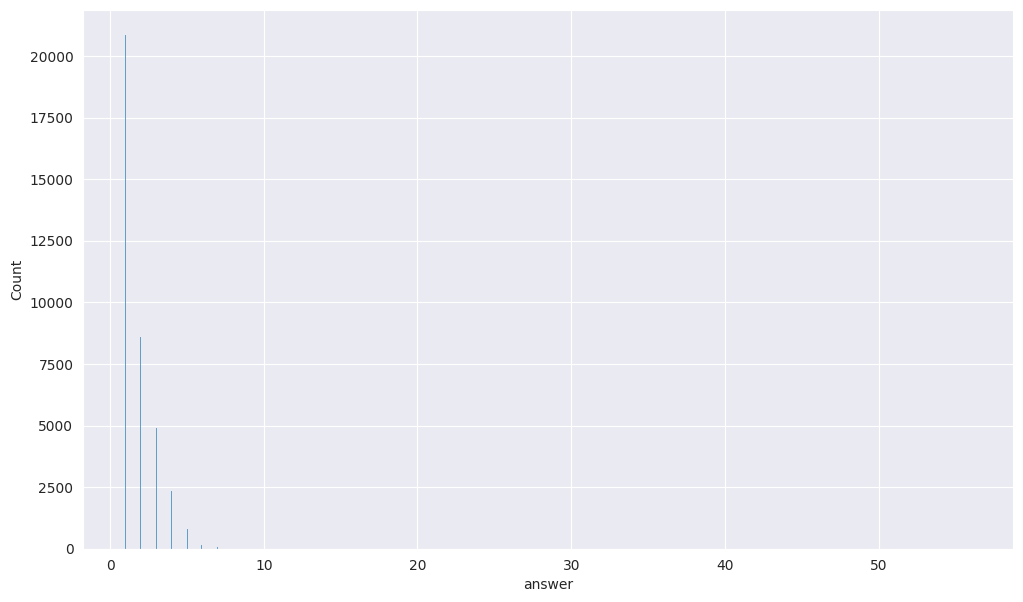

In [ ]:
# plt.figure(figsize=(12, 7))
# sns.histplot(df_["answer"].apply(lambda x: len(x.split())))
# plt.show()


In [ ]:
# (df_["answer"].apply(lambda x: len(x.split())) < 5).sum() / df_.shape[0], df_.shape[0]


(0.9719938471330822, 37706)

In [ ]:
# SBERT

#Load AutoModel from huggingface model repository
sbert_tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
sbert_model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru").to("cuda")

In [ ]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[
        0
    ]  # First element of model_output contains all token embeddings
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


In [ ]:
# tokens = sbert_tokenizer(df.answer.tolist(), padding=True, truncation=True, max_length=24, return_tensors='pt').to("cuda")
# with torch.no_grad():
#     meta = sbert_model(**tokens)
# embs = np.asarray(mean_pooling(meta, tokens['attention_mask']).to("cpu"))
# embs.shape


(35, 1024)

In [ ]:
def sbert_get_embeddings(texts):
    tokens = sbert_tokenizer(list(texts), padding=True, truncation=True, max_length=24, return_tensors='pt').to("cuda")
    with torch.no_grad():
        meta = sbert_model(**tokens)
    embs = np.asarray(mean_pooling(meta, tokens['attention_mask']).to("cpu"))
    return embs


In [ ]:
# import torch
# from transformers import AutoTokenizer, AutoModel

# tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
# model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

# # model.cuda()  # uncomment it if you have a GPU

# def embed_bert_cls(text, model, tokenizer):
#     t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
#     with torch.no_grad():
#         model_output = model(**{k: v.to(model.device) for k, v in t.items()})
#     embeddings = model_output.last_hidden_state[:, 0, :]
#     embeddings = torch.nn.functional.normalize(embeddings)
#     return embeddings.cpu().numpy() # [0]

# print(embed_bert_cls('привет мир', model, tokenizer).shape)
# # (312,)


In [ ]:
# # pip install transformers sentencepiece
# import torch
# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
# model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# # model.cuda()  # uncomment it if you have a GPU

# def embed_bert_cls(text, model, tokenizer):
#     t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
#     with torch.no_grad():
#         model_output = model(**{k: v.to(model.device) for k, v in t.items()})
#     embeddings = model_output.last_hidden_state[:, 0, :]
#     embeddings = torch.nn.functional.normalize(embeddings)
#     return embeddings.cpu().numpy()

# print(embed_bert_cls('привет мир', model, tokenizer).shape)
# # (312,)


In [ ]:
# embs = embed_bert_cls(df["answer"].tolist(), model, tokenizer)
# embs.shape


(48, 312)

# подход с w2v like model'ю

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from string import punctuation

# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.corpus import stopwords
# import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# punctuation_set = set(punctuation)
# stopwords_set = set(stopwords.words("russian")) | set(stopwords.words('english'))
# all_bad_words = stopwords_set | punctuation_set
# morph = pymorphy2.MorphAnalyzer()
# bwre = r"(\s+|^)[пПnрРp]?[3ЗзВBвПnпрРpPАaAаОoO0о]?[сСcCиИuUОoO0оАaAаыЫуУyтТT]?[Ппn][иИuUeEеЕ][зЗ3][ДдDd]\w*[\?\,\.\;\-]*|(\s+|^)[рРpPпПn]?[рРpPоОoO0аАaAзЗ3]?[оОoO0иИuUаАaAcCсСзЗ3тТTуУy]?[XxХх][уУy][йЙеЕeEeяЯ9юЮ]\w*[\?\,\.\;\-]*|(\s+|^)[бпПnБ6][лЛ][яЯ9]([дтДТDT]\w*)?[\?\,\.\;\-]*|(\s+|^)(([зЗоОoO03]?[аАaAтТT]?[ъЪ]?)|(\w+[оОOo0еЕeE]))?[еЕeEиИuUёЁ][бБ6пП]([аАaAиИuUуУy]\w*)?[\?\,\.\;\-]*"


In [ ]:
# # убираем нецензурные слова
# def delete_bad_words(text):
#     return re.sub(bwre, " ", text)

# def normilize_text(text, morph = morph):
#     text = delete_bad_words(text)
#     words = [word for word in word_tokenize(text.lower()) if word not in all_bad_words]
#     words = list(map(lambda x: morph.parse(x)[0].normal_form, words))

#     return words

# normilize_text("Я приехал в Москву и подумал, что бы можно покушать")


['приехать', 'москва', 'подумать', 'покушать']

In [ ]:
# import fasttext
# from huggingface_hub import hf_hub_download

# model_path = hf_hub_download(repo_id="facebook/fasttext-ru-vectors", filename="model.bin")
# model = fasttext.load_model(model_path)


In [ ]:
# def get_embs(words, model=model):
#     embs_list = np.array([model[word] for word in words])
#     # можно макспуллинг, можно эвередж пуллинг
#     embs_list = np.mean(embs_list, axis=0)
#     return embs_list

# get_embs(normilize_text("Я приехал в Москву и подумал, что бы можно покушать")).shape


(300,)

In [ ]:
# df["text"] = df["answer"].apply(normilize_text)
# df["text"] = df["text"].apply(lambda x: x if len(x) > 0 else [""])
# embs = np.array(list(map(get_embs, df["text"])))
# embs.shape


(48, 300)

In [ ]:
# pca = PCA(n_components=30)
# embs = pca.fit_transform(embs)


In [ ]:
# Z = sch.linkage(embs, 'ward')


In [ ]:
# plt.figure(figsize=(10, 7))
# plt.title("Иерархическая кластеризация")
# plt.xlabel("Номер точки")
# plt.ylabel("Расстояние")
# sch.dendrogram(Z, leaf_rotation=0., leaf_font_size=12.,)
# print(plt.xlabel)
# plt.show()


In [ ]:


# dists = cosine_distances(embs)
# dists.shape


(48, 48)

In [ ]:

# ap = AffinityPropagation(random_state=1909, affinity="precomputed").fit(dists)
# df["cluster"] = ap.labels_
# set(ap.labels_)


{0, 1, 2, 3, 4, 5, 6, 7}

In [ ]:
# cluster_points = sch.fcluster(Z, 5, criterion='maxclust')
# df["cluster"] = cluster_points


In [ ]:
# # df.sort_values("cluster")
# df["question"].iloc[0]


'Какие дополнительные предложения от столов необходимо включить в программу?'

In [ ]:
# for (k, v) in df.groupby("cluster"):
#     print(k, v[["answer", "cluster"]])


0                             answer  cluster
1         внутреннее расследование        0
33   развитие "мотивации на жизнь"        0
35    развитие агрессивной рекламы        0
36  разработка единых агитматериал        0
41       упростить документооборот        0
47     эффективность взаимод. с по        0
1                             answer  cluster
2        внутренние  расследования        1
3         расследование бытовых нс        1
4   расследование опасных действий        1
5   расследование опасных действий        1
8   довести численность от до норм        1
15  обучение комм. навыкам лин. ру        1
30           работа с подрядчиками        1
44                 финансирование.        1
2                             answer  cluster
10        исключить «сухое» письмо        2
16  обучение линейных руководителе        2
17  обучение линейных руководителе        2
18  обучение линейных руководителе        2
19  обучение линейных руководителе        2
29  работа с подрядными ор

In [ ]:
# for (k, v) in df.groupby("cluster"):
#     print(k, v[["answer", "cluster"]])


0                             answer  cluster
0               бытовой травматизм        0
1         внутреннее расследование        0
2        внутренние  расследования        0
3         расследование бытовых нс        0
4   расследование опасных действий        0
5   расследование опасных действий        0
14                    обмен опытом        0
1    answer  cluster
12    нет        1
2                             answer  cluster
15  обучение комм. навыкам лин. ру        2
16  обучение линейных руководителе        2
17  обучение линейных руководителе        2
18  обучение линейных руководителе        2
19  обучение линейных руководителе        2
20  обучить всех руководителей паб        2
21  проводить обучение линейных ру        2
22     тотальное обучение линейных        2
3                             answer  cluster
7    контроль знаний от подрядчика        3
9       инфо последствий нарушений        3
11       необходима доп проработка        3
25   пересмотр кпэ по безопасн

In [ ]:
# df[df["cluster"] == 2]["answer"]


15    обучение комм. навыкам лин. ру
16    обучение линейных руководителе
17    обучение линейных руководителе
18    обучение линейных руководителе
19    обучение линейных руководителе
20    обучить всех руководителей паб
21    проводить обучение линейных ру
22       тотальное обучение линейных
Name: answer, dtype: object

In [ ]:
class AnswersClustering:
    def __init__(self, params: dict):
        self.params = params
        # текстовый фиче экстрактор
        self.model = params["model"]
        # тут должен быть конструктор класса
        self.clustering_model = self.params["clustering"](**params["clustering_params"])
        self.emb_list = []
        self.answer_list = []
        self.distance_matrix = None
        self.cluster_list = []

    def add_answer(self, answer: str, recompute: bool):
        # тут хз, когда будем пересчитывать.
        # можно поставить условие на len(self.answer_list)
        # и пересчитывать в зависимости от этого
        self.answer_list.append(answer)
        self.emb_list.append(self.model([answer]).flatten())

        if recompute:
            self.compute_distances()
            self.clustering()
        else:
            self.cluster_list.append(self.clustering_model.predict(self.emb_list[-1]))

    def compute_distances(self):
        self.distance_matrix = cosine_distances(self.emb_list)

    def clustering(self):
        self.clustering_model.fit(self.distance_matrix)
        self.cluster_list = list(self.clustering_model.labels_)

    def get_clusters(self):
        return self.cluster_list

    def get_answers(self):
        return self.answer_list



In [ ]:
params = {
    "model" : sbert_get_embeddings,
    "clustering" : AffinityPropagation,
    "clustering_params" : {
        "random_state" : 1909,
        "affinity" : "precomputed",
    }
}

test_ = AnswersClustering(params)


In [ ]:
# чекал как работает add_answer
for answ in df["answer"]:
    test_.add_answer(answ, True)
    print(test_.get_answers(), test_.get_clusters())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


['> наглядных/раздаточных матер.'] [0]
['> наглядных/раздаточных матер.', 'методичка будет полезной п'] [0, 0]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо'] [0, 0, 0]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат'] [0, 0, 0, 0]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение'] [0, 1, 0, 1, 0]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение', 'времени'] [0, 1, 1, 1, 0, 1]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение', 'времени', 'дискуссия'] [0, 1, 1, 1, 0, 1, 0]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больш

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение', 'времени', 'дискуссия', 'больше выступлений руководства', 'больше практики', 'выделение времени на практичес', 'практику'] [0, 1, 0, 2, 0, 0, 0, 2, 0, 2, 2]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение', 'времени', 'дискуссия', 'больше выступлений руководства', 'больше практики', 'выделение времени на практичес', 'практику', 'вопросы заранее прислать'] [0, 2, 0, 1, 0, 0, 0, 1, 2, 2, 1, 2]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение', 'времени', 'дискуссия', 'больше выступлений руководства', 'больше практики', 'выделение времени на практичес', 'практику', 'вопросы заранее прислать', 'заранее направлять кейсы'] [2, 0, 0, 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение', 'времени', 'дискуссия', 'больше выступлений руководства', 'больше практики', 'выделение времени на практичес', 'практику', 'вопросы заранее прислать', 'заранее направлять кейсы', 'всё норм', 'всё ок'] [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение', 'времени', 'дискуссия', 'больше выступлений руководства', 'больше практики', 'выделение времени на практичес', 'практику', 'вопросы заранее прислать', 'заранее направлять кейсы', 'всё норм', 'всё ок', 'все отлично'] [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
['> наглядных/раздаточных матер.', 'методичка будет полезной п', 'акцент на то как надо', 'больше вним-я обращать на чат', 'больше времени на обсуждение', 'времени', 'дискуссия',

In [ ]:
# тут чекал как кластеризация делает
for k, v in pd.DataFrame({
    "answer" : test_.get_answers(),
    "cluster" : test_.get_clusters(),
}).groupby("cluster"):
    display(v)

,answer,cluster
0,> наглядных/раздаточных матер.,0
13,всё норм,0
14,всё ок,0
20,ничего не менять.,0


,answer,cluster
1,методичка будет полезной п,1
4,больше времени на обсуждение,1
5,времени,1
7,больше выступлений руководства,1
8,больше практики,1
10,практику,1
11,вопросы заранее прислать,1
12,заранее направлять кейсы,1
15,все отлично,1
23,чаще проводить,1


,answer,cluster
6,дискуссия,2
16,все устраивает. можно чаще,2
18,ни чего,2
19,ничего,2
30,тайминг,2
34,формат мозгового штурма,2


,answer,cluster
2,акцент на то как надо,3
3,больше вним-я обращать на чат,3
9,выделение времени на практичес,3
17,нет,3
21,делать почаще такие тренинги,3
22,проводить мероприятия чаще,3
25,новое в свкиа,3
27,побольше кофе-брейков,3
28,примеры правильного заполнения,3
29,сделать более комфортный тайми,3


In [ ]:
# tsne = TSNE(n_components=2)
# tsne_res = tsne.fit_transform(np.array(embs))


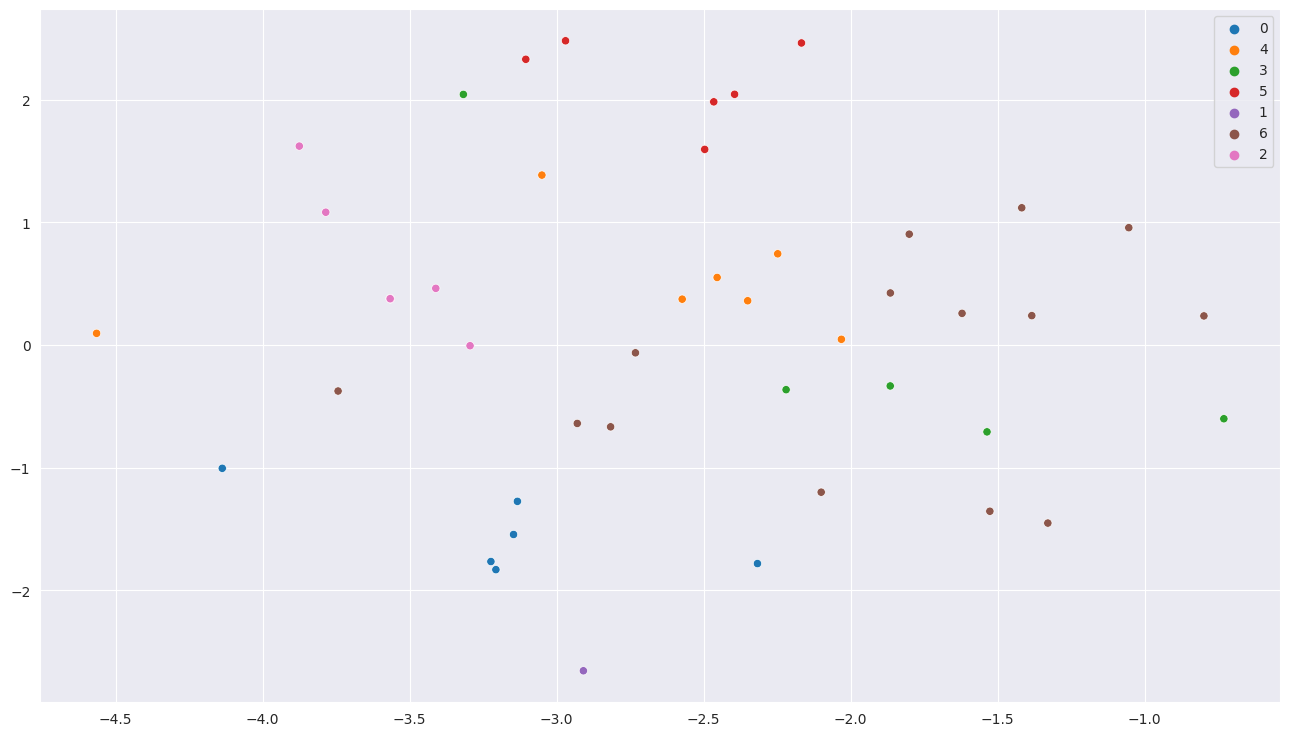

In [ ]:
# plt.figure(figsize=(16, 9))
# sns.scatterplot(
#     x=tsne_res[:, 0],
#     y=tsne_res[:, 1],
#     hue=map(str, df["cluster"]),
# )
# plt.show()
